In [77]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict
import math

In [78]:
def visual_object(object_, caption=""):
    if caption:
        print(f"{caption}")

    plt.imshow(object_)
    plt.axis('off')
    plt.show()


def draw_clustered_lines(lines, clusters):
    black_image = np.zeros((height, width, 3), dtype=np.uint8)
    image = black_image
    colors = [(255, 0, 0), (0, 0, 255), (255, 255, 255)]
    
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        cluster_idx = clusters[i]
        color = colors[cluster_idx % len(colors)]
        cv2.line(image, (x1,y1), (x2,y2), color, 2)
    
    return image

In [79]:
image = cv2.imread("/kaggle/input/cv-homeworks-lab1/road1.png")

height, width, _ = image.shape

Original image!


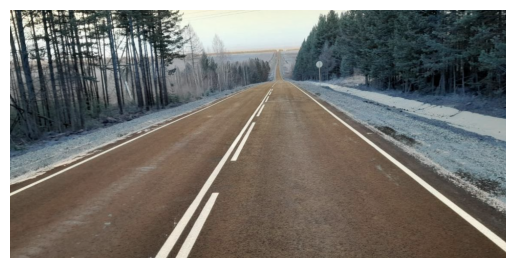

In [80]:
visual_object(image, caption="Original image!")

In [81]:
black_image = np.zeros((height, width, 3), dtype=np.uint8)

In [82]:
def detect_edges_with_canny(img, threshold1, threshold2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, threshold1, threshold2)

    return edges

In [83]:
threshold1, threshold2 = 400, 350
edges = detect_edges_with_canny(image, threshold1, threshold2)

edges by Canny


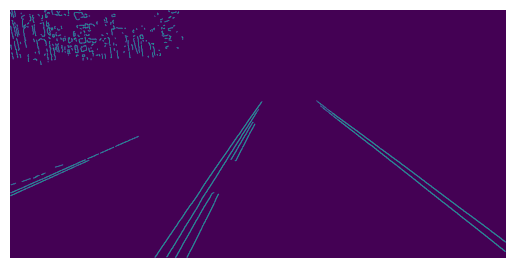

In [84]:
visual_object(edges, caption="edges by Canny")

In [85]:
def find_straight_lines(edges):
    lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi / 180,
            threshold=100,
            minLineLength=170,
            maxLineGap=5,
        )
    
    return lines

In [86]:
lines = find_straight_lines(edges)

lines = sorted(lines, key=lambda x : x[0][0])

len(lines)=10
Hough Lines


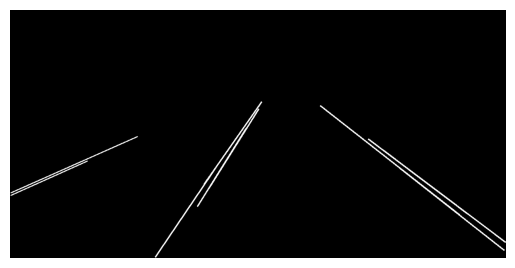

In [87]:
black_image_lines = black_image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(black_image_lines, (x1, y1), (x2, y2), (255, 255, 255), 2)


print(f"{len(lines)=}")
visual_object(black_image_lines, caption="Hough Lines")

In [88]:
lines_dict = defaultdict(dict)

for line in lines:
    x1, y1, x2, y2 = line[0]
    lines_dict[len(lines_dict)] = {"line" : line, "x_min" : (x1 + x2) // 2, "lenght" : math.sqrt((x2-x1)**2 + (y2-y1)**2)}


line_params = [[lines_dict[ind]["x_min"]] for ind in lines_dict]

In [89]:
n_clusters=3

kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(line_params)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clusters lines


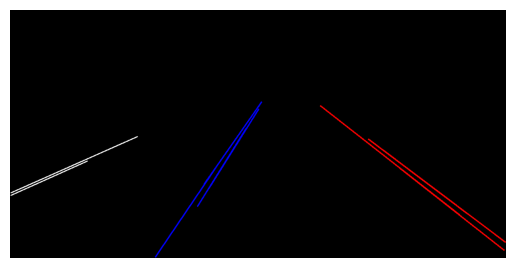

In [90]:
black_image_lines = draw_clustered_lines(lines, clusters)

visual_object(black_image_lines, caption="clusters lines")

In [91]:
dict_clusters_lines = defaultdict(list)

for ind, cl in enumerate(clusters):
    dict_clusters_lines[cl].append(lines_dict[ind])

In [92]:
max_line_size = defaultdict(dict)

for cl in dict_clusters_lines:
    for line in dict_clusters_lines[cl]:
        if not max_line_size[cl]:
            max_line_size[cl]["lenght"] = line["lenght"]
            max_line_size[cl]["most_line"] = line
        else:
            if line["lenght"] > max_line_size[cl]["lenght"]:
                max_line_size[cl]["lenght"] = line["lenght"]
                max_line_size[cl]["most_line"] = line

In [93]:
max_line_size

defaultdict(dict,
            {2: {'lenght': 328.16002194051606,
              'most_line': {'line': array([[  2, 435, 302, 302]], dtype=int32),
               'x_min': 152,
               'lenght': 328.16002194051606}},
             1: {'lenght': 254.8921340488953,
              'most_line': {'line': array([[345, 587, 488, 376]], dtype=int32),
               'x_min': 416,
               'lenght': 254.8921340488953}},
             0: {'lenght': 418.88423221696945,
              'most_line': {'line': array([[ 737,  229, 1067,  487]], dtype=int32),
               'x_min': 902,
               'lenght': 418.88423221696945}}})

In [94]:
final_lines = [max_line_size[cl]["most_line"]["line"] for cl in max_line_size]
final_clusters = [cl for cl in max_line_size]

Final cluster lines


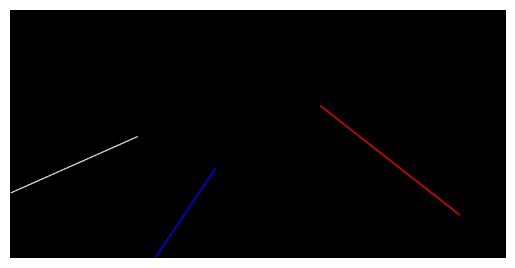

In [95]:
final_black_image = draw_clustered_lines(final_lines, final_clusters)
visual_object(final_black_image, caption="Final cluster lines")

## Calculate line location

In [96]:
center_w, center_h = width // 2, height // 2

print(f"{width, height      = }")
print(f"{center_w, center_h = }")

width, height      = (1178, 590)
center_w, center_h = (589, 295)


In [97]:
def point_relative_to_line(line, center):
    x1, y1, x2, y2 = line[0]
    p1 = (x1, y1)
    p2 = center
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    cross_product =  np.rad2deg((ang1 - ang2) % (2 * np.pi))
    
    if cross_product > 180:
        return "left"
    elif cross_product < 180:
        return "right"
    else:
        return "on_line"


center_line = final_lines[1]
result_position = point_relative_to_line(center_line, (width//2, height//2))

print(f" The center of image is located on {result_position} road line!")

 The center of image is located on right road line!


## Calculate line intersection

In [98]:
def find_intersection(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    
    A1 = y2 - y1
    B1 = x1 - x2
    C1 = x2*y1 - x1*y2
    
    A2 = y4 - y3
    B2 = x3 - x4
    C2 = x4*y3 - x3*y4
    
    denominator = A1*B2 - A2*B1
    
    if denominator == 0:
        return None

    x = (B1*C2 - B2*C1) / denominator
    y = (A2*C1 - A1*C2) / denominator
    
    return (x, y)

In [99]:
x_inter, y_inter = map(int, find_intersection(final_lines[1], final_lines[2]))

In [100]:
final_black_image = cv2.circle(final_black_image, (x_inter, y_inter), 5, (0, 255, 0), -1)

The result image with green intersection point!


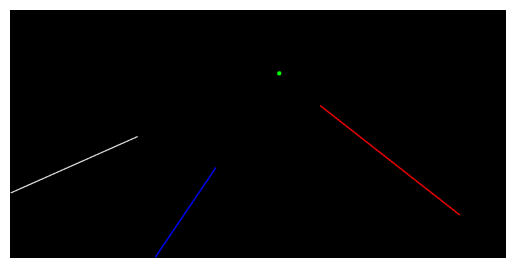

In [101]:
visual_object(final_black_image, caption="The result image with green intersection point!")